# Fractions Skill Score (FSS)

The original paper, and formal definitions can be found here:  

Roberts, N. M., & Lean, H. W. (2008). Scale-Selective Verification of Rainfall Accumulations from High-Resolution Forecasts of Convective Events. Monthly Weather Review, 136(1), 78-97. https://doi.org/10.1175/2007MWR2123.1


For an explanation of the FSS, and implementation considerations, see:  

Faggian, N., Roux, B., Steinle, P., & Ebert, B. (2015). Fast calculation of the fractions skill score. MAUSAM, 66(3), 457–466. https://doi.org/10.54302/mausam.v66i3.555

## FSS for a single 2D field
FSS is computed over 2D arrays representing the observations & forecasts in the spatial domain. The user has to make sure that the input dimensions correspond to the spatial domain e.g. `lat x lon`. Generally the computation involves sliding a window over the input field(s) and applying a threshold over the fcst and obs values.

The resulting binary field is summed up to represent the populace (number of ones/"true" values in the window).

The resulting 2-D field of rolling sums represents ["_Integral Image_"][integral_image] of the respective forecast and observation fields, which is then aggregated over all the sliding windows to compute the FSS. 

The FSS is then roughly defined as:
$$
    FSS = 1 - \frac{\sum_{w}(p_o - p_f)^2}{\sum_{w}p_o^2 + \sum_{w}p_f^2}
$$

where,

- $p_o$ is the observation populace > threshold, in one window
- $p_f$ is the forecast populace > threshold, in one window
- $\sum_{w}$ is the sum over all windows


The numerator in the FSS equation is analogous to the Brier score, and it is referred to as the Fractions Brier Score (FBS) that is bounded by 0 (perfect) and 1 (worst). FBS can be defined as:
$$
    FBS = \frac{1}{N_x N_y}{\sum_{i=1}^{N_x}\sum_{j=1}^{N_y}(F_{ij} - O_{ij})^2}
$$

where,

- $O_{ij}$ is the fraction of observation exceeding an event threshold within a neighborhood window
- $F_{ij}$ is the fraction of forecast exceeding an event threshold within a neighborhood window


The denominator in the FSS equation denotes the reference forecast which defined as the largest possible squared difference that could be obtained when the forecast and observation fractions are completely anti-correlated (Check [Mittermaier 2025](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.4877) for more detail). $\text{FBS}_{\text{ref}}$ is defined as:
$$
    \text{FBS}_{\text{ref}} = \frac{1}{N_x N_y} \left[ \sum_{i=1}^{N_x}\sum_{j=1}^{N_y} F_{ij}^2 + \sum_{i=1}^{N_x}\sum_{j=1}^{N_y} O_{ij}^2 \right]
$$

$\text{FBS}_{\text{ref}}$ is bounded by 0 (i.e., completely dry case) and 2 (i.e., completely wet case where forecast and observation fractions are 1 and perfectly agree).

Please note that FSS implementation in *scores* calculates $\text{FBS}$ and $\text{FBS}_{\text{ref}}$ along with $\text{FSS}$.

The implementation details are beyond the scope of this tutorial please refer to, [Fast calculation of the Fractions Skill Score][fss_ref] for more information.

In summary, computation of a single field requires the following parameters:

- forecast 2-D field (in spatial domain)
- observations 2-D field (in spatial domain)
- window size (width x height): The window size of the sliding window
- threshold: To compare the input fields against to generate a binary field
- compute method: (optional) currently only `numpy` is supported

[fss_ref]: http://dx.doi.org/10.54302/mausam.v66i3.555
[integral_image]: https://en.wikipedia.org/wiki/Summed-area_table

### 1. Setup ###

First let's create some random data for our forecast and observation fields. Let's also try out a few scenarios:
```
scenario 1: obs distribution = fcst distribution = N(0, 1)
scenario 2: fcst distribution biased = N(1, 1)
scenario 3: fcst distribution variant = N(0, 2)

where N(mu, sigma) = normal distribution with mean = mu and standard deviation = sigma
```

> Note: in practice, some fields like rainfall cannot be negative. The data is synthesized, purely to show the steps required to compute the score.

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter

from scores.spatial import fss_2d_single_field, fss_2d
from scores.processing.discretise import comparative_discretise


In [2]:
# specify input spatial dimensions
num_cols = 600
num_rows = 400

# set seed for reproducibility
np.random.seed(42)

# generate random fields
obs = np.random.normal(loc=0.0, scale=1.0, size = (num_rows, num_cols))
fcst_1 = np.random.normal(loc=0.0, scale=1.0, size = (num_rows, num_cols))
fcst_2 = np.random.normal(loc=1.0, scale=1.0, size = (num_rows, num_cols))
fcst_3 = np.random.normal(loc=0.0, scale=2.0, size = (num_rows, num_cols))
fcst_4 = np.random.normal(loc=1.0, scale=2.0, size = (num_rows, num_cols))

# print out the different scenarios
_summarize = lambda x, field: print(
    "{: >20}: shape={}, mean={:.2f}, stddev={:.2f}".format(
    field, x.shape, np.mean(x), np.std(x)
))
_summarize(obs, "observations")
_summarize(fcst_1, "forecast scenario 1")
_summarize(fcst_2, "forecast scenario 2")
_summarize(fcst_3, "forecast scenario 3")
_summarize(fcst_4, "forecast scenario 4")


        observations: shape=(400, 600), mean=0.00, stddev=1.00
 forecast scenario 1: shape=(400, 600), mean=-0.00, stddev=1.00
 forecast scenario 2: shape=(400, 600), mean=1.00, stddev=1.00
 forecast scenario 3: shape=(400, 600), mean=-0.01, stddev=2.00
 forecast scenario 4: shape=(400, 600), mean=1.00, stddev=2.01


### 2. Define inputs ###

We need to now specify the threshold, window size and compute method. For now, lets choose a single window, and threshold. While the current `fss` method doesn't allow for more than 1 threshold and window definition per call, we'll see how calculate multiple thresholds/windows in a later step. Traditionally, the neighborhood window used in FSS calculations is a square of width $2n + 1$ centered at grid cell $(i, j)$, where $0 \le n \ge \max(N_x, N_y)$. However, in this implementation, users can independently define the height and width of the window, allowing for a rectangular neighborhood.

In [3]:
window_size = (100, 100)  # height * width or row size * col size
threshold = 0.5  # arbitrarily chosen

# Note: the compute method is a specialized argument, it doesn't need to be specified but is shown here for illustration purposes.
# If you do not specify a compute method it will default to `NUMPY` which is the only method currently supported and is sufficient
# for most purposes.
from scores.fast.fss.typing import FssComputeMethod
compute_method = FssComputeMethod.NUMPY

print("window_size:", window_size)
print("threshold:", threshold)
print("compute_method:", compute_method)

window_size: (100, 100)
threshold: 0.5
compute_method: FssComputeMethod.NUMPY


### 3. Run FSS ###

Since we only have spatial dims it is sufficient to use  `scores.spatial.fss_2d_single_field` for this purpose.

Here are reasons why a user may prefer to use this API:

- The user can choose their own aggregation method
- The user wants more choice on how to parallelize the computations.
- The user wants to compute multiple windows/thresholds without the overhead of `xarray`.

In practice however, the aggregated approach `scores.spatial.fss_2d` in the next part can potentially be simpler to use, especially for more common data types used in the field i.e. `NetCDF/xarray`

In [4]:
# compile scenarios
scenarios = {
    "scenario 1 (same distribution)": [obs, fcst_1],
    "scenario 2 (biased fcst)": [obs, fcst_2],
    "scenario 3 (variant fcst)": [obs, fcst_3],
    "scenario 4 (biased and variant fcst)": [obs, fcst_4],
}
result = []

# run through each scenario and compute FSS with inputs defined above
for s, v in scenarios.items():
    _obs, _fcst = v
    _fss = fss_2d_single_field(
        _fcst,
        _obs,
        event_threshold=threshold,
        window_size=window_size,
        compute_method=compute_method,
    )
    result.append((s, _fss))

# tabulate results
print(f"{' '*30} | fss score")
print(f"{' '*30} | ---------")
_ = [print("{:<30} | {}".format(s, v)) for (s, v) in result]

                               | fss score
                               | ---------
scenario 1 (same distribution) | {'FSS': np.float64(0.9998031509754236), 'FBS': np.float64(3.734243148254984e-05), 'FBS_ref': np.float64(0.18970087132969943)}
scenario 2 (biased fcst)       | {'FSS': np.float64(0.7436622752127978), 'FBS': np.float64(0.1467819040475859), 'FBS_ref': np.float64(0.5726114022796931)}
scenario 3 (variant fcst)      | {'FSS': np.float64(0.9658938686575778), 'FBS': np.float64(0.008730863491488784), 'FBS_ref': np.float64(0.2559910241308745)}
scenario 4 (biased and variant fcst) | {'FSS': np.float64(0.814066308768751), 'FBS': np.float64(0.08417482256118991), 'FBS_ref': np.float64(0.4527142015187565)}


As apparent above, with the same distribution, we get a score close to 1, this is because FSS is invariant to the exact location within the sliding window where the binary fields match, and so only the total count is used. With a biased distribution the score dips a lot, which is expected with a threshold of 0.5 and a bias of 1.0. Whereas for a variant forecast, we still get a reasonable score, this is also expected since the variation is not too large and the distributions still overlap quite a bit.

### 4. Multiple inputs ###

Suppose now that we want to collate data for multiple thresholds/windows. There are several ways of doing this, including vectorization. The following will show one way of doing it that, while more verbose, would hopefully help decompose the operations required to create the final accumulated dataset.

Now that we understand how the argument mapping works, let's re-create the mapping and run the fss, we will also store the results in a `W x T x S` array before converting it to xarray for displaying.
```
W x T x S where,
W = number of windows
T = number of thresholds
S = number of scenarios
```

But now first let's try to create synthetic 3-hourly precipitation fields across different forecast systems.
```
Observation field: Simulated using Gaussian blobs to represent convective storms. Please note that the rainfall intensity is applied over small patches to mimic storm cores and Gaussian smoothing is used to create realistic storm structures.

Scenario 1 - Slight Spatial Displacement: Forecast storms are located near the observed storm centers (small random offsets are simulated to create errors in storm positioning).

Scenario 2 - Storms at Different Locations: Forecast storms are placed in locations far from the observed ones, representing a poor forecast with low spatial correlation to the reality.

Scenario 3 - Misplacement: Forecast storms are concentrated in a small region far from observed storm area, representing a forecast that completely misplaced the storms.
```

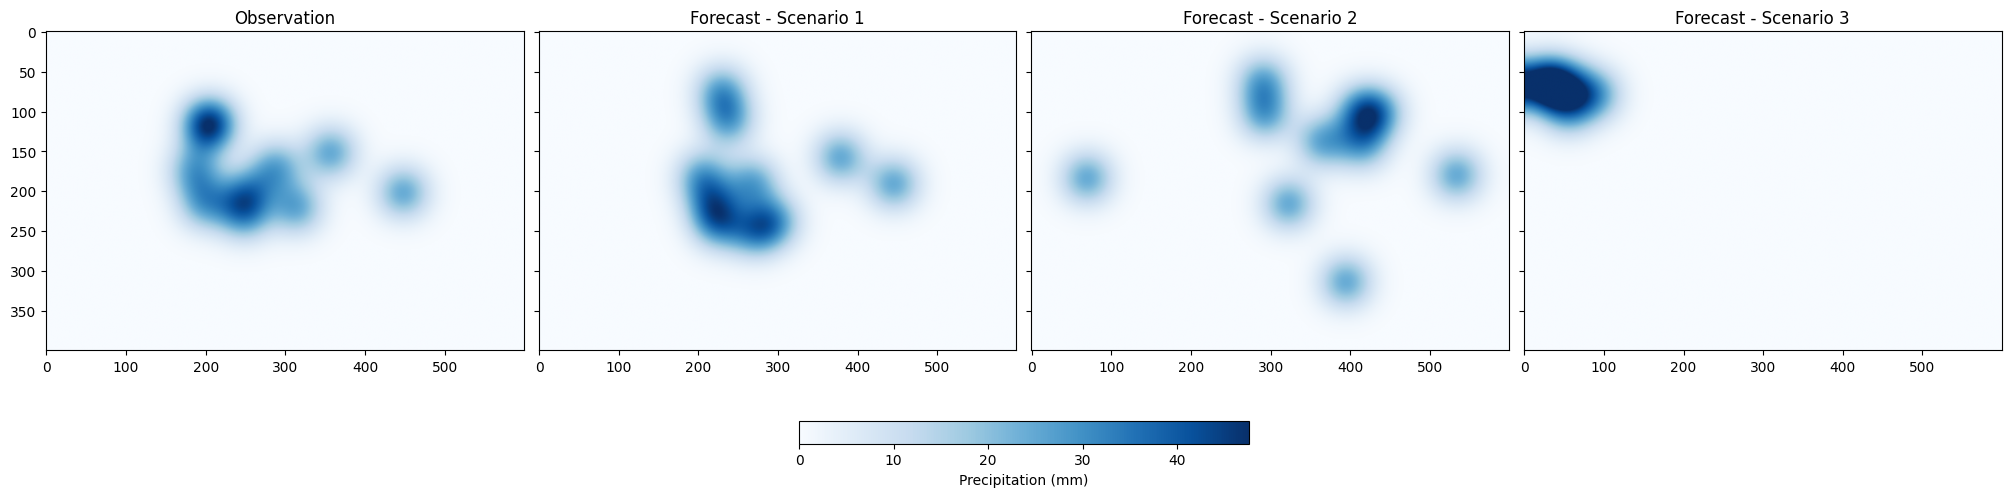

In [5]:
def generate_precipitation_field(shape, centers, intensity=50, spread=20, patch_size=40):
    """
    Generate synthetic precipitation field with Gaussian blobs representing convective storms.
    """
    field = np.zeros(shape)
    half_patch = patch_size // 2
    for x, y in centers:
            blob = np.zeros(shape)
            # Apply intensity over a square patch centered at (x, y)
            for i in range(-half_patch, half_patch + 1):
                for j in range(-half_patch, half_patch + 1):
                    xi, yj = x + i, y + j
                    if 0 <= xi < shape[0] and 0 <= yj < shape[1]:
                        blob[xi, yj] = intensity
            field += gaussian_filter(blob, sigma=spread)
    return field

# Grid shape
shape = (400, 600)

# Generate storm centers for forecast and observation
np.random.seed(42)
centers_obs = [(np.random.randint(100, 300), np.random.randint(100, 500)) for _ in range(10)]
centers_fcst_1 = [(x + np.random.randint(-40, 40), y + np.random.randint(-40, 40)) for x, y in centers_obs]
centers_fcst_2 = [(np.random.randint(50, 350), np.random.randint(50, 550)) for _ in range(10)]
centers_fcst_3 = [(np.random.randint(20, 100), np.random.randint(20, 100)) for _ in range(5)]
obs_field = generate_precipitation_field(shape, centers_obs)
fcst_field_1 = generate_precipitation_field(shape, centers_fcst_1)
fcst_field_2 = generate_precipitation_field(shape, centers_fcst_2, intensity=50, spread=20)
fcst_field_3 = generate_precipitation_field(shape, centers_fcst_3, intensity=50, spread=20)

vmin = min(obs_field.min(), fcst_field_1.min(), fcst_field_2.min(), fcst_field_3.min())
vmax = min(obs_field.max(), fcst_field_1.max(), fcst_field_2.max(), fcst_field_3.max())

fig, axes = plt.subplots(1, 4, figsize=(20, 6), constrained_layout=True, sharey=True)

titles = ['Observation', 'Forecast - Scenario 1', 'Forecast - Scenario 2', 'Forecast - Scenario 3']
fields = [obs_field, fcst_field_1, fcst_field_2, fcst_field_3]
for ax, field, title in zip(axes, fields, titles):
     im = ax.imshow(field, cmap='Blues', vmin=vmin, vmax=vmax)
     ax.set_title(title)
    #  ax.axis('off')


cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Precipitation (mm)')
plt.show()

o calculate the FSS, we apply a square neighborhood window with widths ranging from 1 (indicating no spatial smoothing) to 399 (capturing a broad spatial extent), and use event thresholds from 1 mm (light rainfall) to 20 mm (heavy rainfall).

In [6]:
# as before
window_sizes = np.array([[1, 1], [11, 11], [33, 33], [77, 77], [121, 121], [225, 225], [399, 399]])
thresholds = np.array([1, 4, 8, 16, 20])
input_scenarios = [[obs_field, fcst_field_1], [obs_field, fcst_field_2], [obs_field, fcst_field_3]]
compute_method = FssComputeMethod.NUMPY

# create output array
W = len(window_sizes)
T = len(thresholds)
S = len(input_scenarios)
fss_out = np.zeros((W, T, S))
fbs_out = np.zeros((W, T, S))
fbs_ref_out = np.zeros((W, T, S))
# lets iterate over the indices, setting the `multi_index` and `writeonly` flags
with np.nditer([fss_out, fbs_out, fbs_ref_out], flags=['multi_index'], op_flags=['writeonly']) as it:
    for (_fss, _fbs, _fbs_ref) in it:
        # gather argument indices
        window_idx, threshold_idx, input_idx = it.multi_index
        _window_size = window_sizes[window_idx]
        _threshold = thresholds[threshold_idx]
        _obs, _fcst = input_scenarios[input_idx]
        # compute the fss for each combination of arguments
        res = fss_2d_single_field(
            _fcst,
            _obs,
            event_threshold=_threshold,
            window_size=_window_size,
            compute_method=compute_method,
            padding='zero'
        )
        _fss[...] = res['FSS']
        _fbs[...] = res['FBS']
        _fbs_ref[...] = res['FBS_ref']

# construct output xarray dataset with results
FSS_ds = xr.Dataset(
    data_vars={
        'FSS': (("window_size", "threshold", "scenario"), fss_out),
        'FBS': (("window_size", "threshold", "scenario"), fbs_out),
        'FBS_ref': (("window_size", "threshold", "scenario"), fbs_ref_out),
    },
    coords=dict(
        window_size=[str(x) for x in window_sizes],
        threshold=[x for x in thresholds],
        scenario=range(len(input_scenarios))
    ),
    attrs=dict(
        description="Fractions skill score",
    ),
)
FSS_ds

<xarray.Dataset> Size: 3kB
Dimensions:      (window_size: 7, threshold: 5, scenario: 3)
Coordinates:
  * window_size  (window_size) <U9 252B '[1 1]' '[11 11]' ... '[399 399]'
  * threshold    (threshold) int64 40B 1 4 8 16 20
  * scenario     (scenario) int64 24B 0 1 2
Data variables:
    FSS          (window_size, threshold, scenario) float64 840B 0.8568 ... 0...
    FBS          (window_size, threshold, scenario) float64 840B 0.07283 ... ...
    FBS_ref      (window_size, threshold, scenario) float64 840B 0.5085 ... 0...
Attributes:
    description:  Fractions skill score

Now let's try to plot the calculated FSS values for different event thresholds and neighborhood window sizes.

As shown in the results:

- Scenario 1 (slight spatial displacement) consistently yields the highest FSS value, whereas Scenario 3 (large misplacement) resulted in the lowest FSS values, as expected.
- Increasing the event threshold generally leads to decrease in FSS since higher thresholds reduce the number of matched events.
- Increasing the neighborhood window size improves FSS values due to spatial smoothing, which helps mitigate the impact of storm displacement.

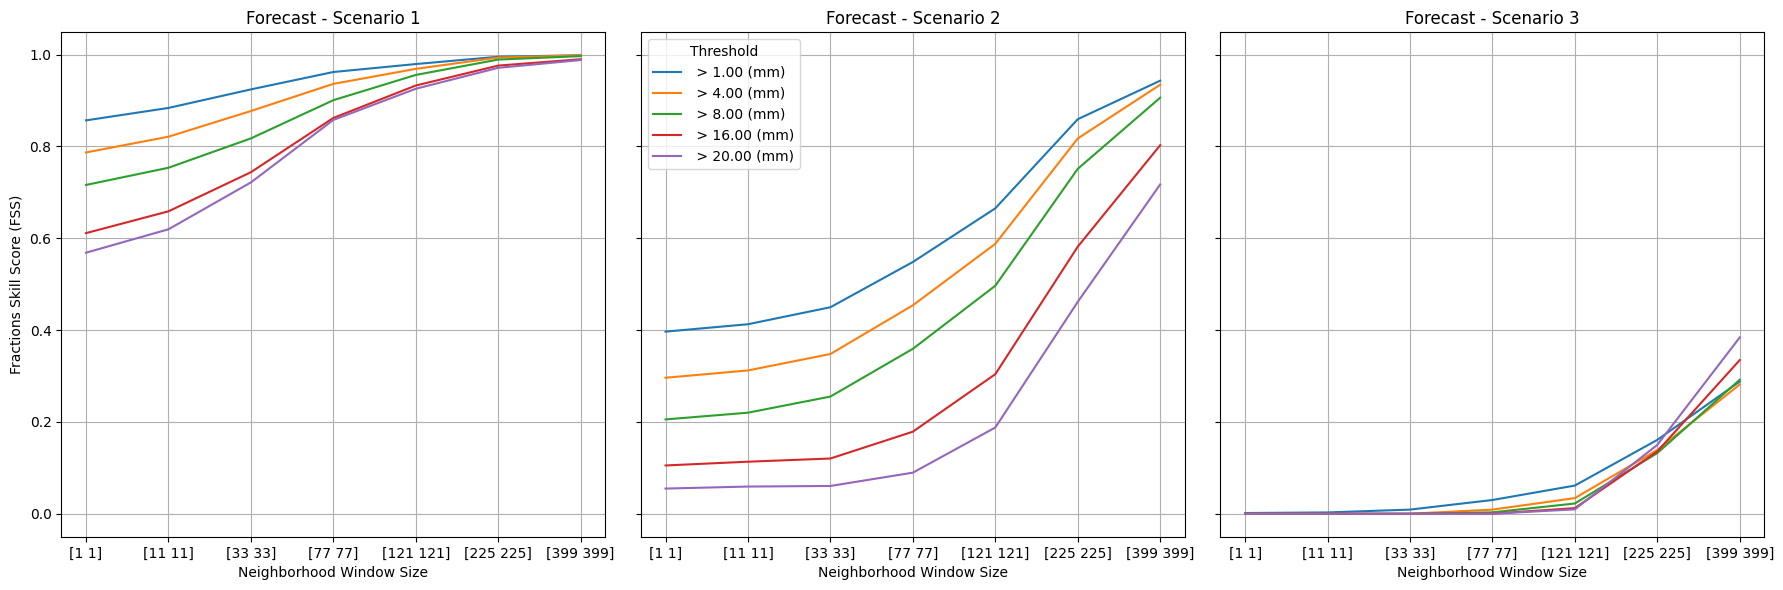

In [7]:

window_size_labels = FSS_ds.window_size.values
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
titles = ['Forecast - Scenario 1', 'Forecast - Scenario 2', 'Forecast - Scenario 3']
fields = [obs_field, fcst_field_1, fcst_field_2, fcst_field_3]
for ax, scenario, title in zip(axes, [0, 1, 2], titles):
    fss_single = FSS_ds['FSS'].sel(scenario=scenario)
    for i, threshold in enumerate((FSS_ds.threshold.values)):
        ax.plot(window_size_labels, fss_single[:, i].values, label=f" > {threshold:.2f} (mm)")
     
    ax.set_title(title)
    ax.set_xlabel('Neighborhood Window Size')
    
    ax.tick_params(axis='both', which='major')
    ax.grid(True)


axes[0].set_ylabel('Fractions Skill Score (FSS)')
axes[1].legend(title='Threshold')
plt.grid(True)
plt.tight_layout()
plt.show()


Please note that the example above is intended solely to demonstrate how FSS can be calculated across different event thresholds and neighborhood window sizes, and how the results can be visualized. In real-world scenarios, the FSS curve may plateau at much smaller neighborhood window sizes.

When calculating the Fractions Skill Score (FSS), users can choose how to handle the edges of the precipitation fields. This becomes especially important when using large neighborhood window sizes, as windows near the edges may extend beyond the available data.

Without padding, these edge windows get truncated, leading to:

- Inconsistent comparisons
- Reduced effective window size
- Potential bias in FSS values

To address this, padding is recommended. In this demonstration, we provide three approaches:

- No Padding (default): Windows near the edges are truncated.
- Zero Padding: A border of zeros is added around the field, simulating no precipitation beyond the edges.
- Reflective Padding: Edge values are mirrored outward, preserving spatial continuity.

## Aggregated FSS

The aggregated FSS groups a list of 2-D spatial fields from the input data array and applies the single 2D FSS in the previous section over each field. It then accumulates the decomposed scores into the final score. A description of the algorithm is provided at the bottom of this tutorial.


### 1. Setup ###

Similar to the previous section lets start by setting up our inputs. This time we will include the scenarios within the input source itself. Let's define our inputs:

```
Fcst
----
Dims: T x L x N x M

Obs
---
Dims: T x N x M

where,
  T = time - 3 hourly precipitation over two days
  L = lead time - 8 lead times (3h to 24h in 3-hour intervals)
  N = lat_idx [0..400]
  M = lon_idx [0..600]
```

We will also assume that the variance and bias increase as the lead time increases


In [8]:
# Define constants (you can tweak them to create different synthetic fields)
ny, nx = 400, 600
lat = np.linspace(-20, -16, ny)
lon = np.linspace(148, 156, nx)
t0 = np.datetime64("2025-01-01T00:00")
steps = 16
leads = (1, 2, 3, 4, 5, 6, 7, 8) # 3h..18h lead
rseed = 42 # global seed

rng = np.random.default_rng(rseed)
time = t0 + np.arange(steps) * np.timedelta64(3, "h")
Lon, Lat = np.meshgrid(lon, lat)

# Let's first create our observation field.
# broad stratiform background + one moving Gaussian convective storm
bg = 1.2 * np.exp(-(((Lon-152)/3.0)**2 + ((Lat+18.3)/1.6)**2))
lon0, lat0, u, v = 149.8, -19.0, 0.18, 0.05
sigx, sigy, amp = 0.25, 0.18, 18.0

data = np.zeros((steps, ny, nx), np.float32)
# Let's now include a diurnal cycle
for k in range(steps):
    hour = (k * 3) % 24
    diurn = max(0.0, 0.5 * (1 + np.sin(2*np.pi * (hour-16)/24)))
    cx, cy = lon0 + u*k, lat0 + v*k
    conv = amp * np.exp(-(((Lon-cx)**2)/(2*sigx**2) + ((Lat-cy)**2)/(2*sigy**2))) * diurn
    noise = rng.gamma(1.1, 0.45, size=(ny, nx))
    field = bg + conv + noise
    thresh = 1.4 + 1.0*(1 - diurn)
    data[k] = np.clip(np.where(field > thresh, field, 0.0), 0, 60.0)

da_obs = xr.DataArray(
    data, dims=("time","lat","lon"),
    coords=dict(time=time, lat=lat, lon=lon),
    name="precip_rate",
    attrs=dict(units="mm hr-1", description="3-hourly precipitation")
)

# Let's now create the forecast DataArray. We include various errors (e.g.,
# phase error spatial displacement) in the forecast field
dlat, dlon = float(lat[1]-lat[0]), float(lon[1]-lon[0])
leads = np.asarray(leads, int)

def shift(a, dlat_deg, dlon_deg):
    di = int(round(dlat_deg/dlat)); dj = int(round(dlon_deg/dlon))
    return np.roll(np.roll(a, -di, axis=0), dj, axis=1)

def blur3(a, n=1):
    for _ in range(n):
        a = (a + np.roll(a,1,0) + np.roll(a,-1,0) +
                np.roll(a,1,1) + np.roll(a,-1,1)) / 5.0
    return a.astype(np.float32)

out = np.zeros((da_obs.sizes["time"], len(leads), ny, nx), np.float32)
for t in range(da_obs.sizes["time"]):
    truth = da_obs.isel(time=t).values.astype(np.float32)
    for li, L in enumerate(leads):
        f = truth * (1.01 + 0.2*L) # mild bias
        f = shift(f, dlat_deg=-0.03*L, dlon_deg=0.06*L) # drift with lead
        for _ in range(max(1, L//2)): # light smoothing grows with lead
            f = blur3(f).astype(np.float32)
        f += rng.gamma(1.1, 0.1, size=(ny, nx)).astype(np.float32) # noise
        out[t, li] = np.clip(f, 0, 60.0)

da_fcst = xr.DataArray(
    out, dims=("time","lead_time","lat","lon"),
    coords=dict(time=da_obs.time.values, lead_time=("lead_time", leads), lat=lat, lon=lon),
    name="precip_rate",
    attrs=dict(
        units="mm hr-1",
        description="Forecast - 3-h hourly precipitation"
    )
)

In [9]:
# check fcst coordinates
da_fcst.coords

Coordinates:
  * time       (time) datetime64[s] 128B 2025-01-01 ... 2025-01-02T21:00:00
  * lead_time  (lead_time) int64 64B 1 2 3 4 5 6 7 8
  * lat        (lat) float64 3kB -20.0 -19.99 -19.98 ... -16.02 -16.01 -16.0
  * lon        (lon) float64 5kB 148.0 148.0 148.0 148.0 ... 156.0 156.0 156.0

In [10]:
# check obs coordinates
da_obs.coords

Coordinates:
  * time     (time) datetime64[s] 128B 2025-01-01 ... 2025-01-02T21:00:00
  * lat      (lat) float64 3kB -20.0 -19.99 -19.98 ... -16.02 -16.01 -16.0
  * lon      (lon) float64 5kB 148.0 148.0 148.0 148.0 ... 156.0 156.0 156.0

### 2. Run Aggregate FSS ###

We choose accumulation dimensions and run FSS. Here we want to preserve the `lead_time`, and calculate the `fss` reduced over space (`lat`, `lon`) followed by `time`.

Here we use `scores.spatial.fss_2d` which automatically tries to compute the decomposed `fss` score for each dimension reduced over space using `scores.spatial.fss_2d_single_field` similar to the previous section.

Additionally it can take in `preserve_dims` or (mutually exclusive) `reduce_dims` function arguments to determine which dimensions to aggregate over.

In [11]:
# As before we currently only support a single threshold/window argument.
threshold = 0.5
window_size = (100, 100)


# since our input arrays already encapsulate the various scenarios in the time/lead time dimensions,
# we just need to provide the inputs

# IMPORTANT: Note that we need to provide the names of the spatial_dims explicitly, unlike in the previous
# section, where the input is assumed to be a 2D spatial field, this function doesn't know which dimensions
# are spatial unless you tell it.
fss_out = fss_2d(
    da_fcst,
    da_obs,
    event_threshold=threshold,
    window_size=window_size,
    spatial_dims=["lat", "lon"],
    preserve_dims=["lead_time"],
    padding='reflective'
)
fss_out


<xarray.Dataset> Size: 256B
Dimensions:    (lead_time: 8)
Coordinates:
  * lead_time  (lead_time) int64 64B 1 2 3 4 5 6 7 8
Data variables:
    FSS        (lead_time) float64 64B 0.7256 0.6764 0.6527 ... 0.5302 0.4933
    FBS        (lead_time) float64 64B 0.04043 0.05498 0.06314 ... 0.1218 0.1473
    FBS_ref    (lead_time) float64 64B 0.1473 0.1699 0.1818 ... 0.2593 0.2908

**Result:** We should now see a dataset of FSS values with only `lead_time` as the preserved dimension. If we look at the data, the FSS decreases as the leadtime increases, because we made our simulated data distribution shift away from the obs as the lead time increased. So this roughly looks like what we'd expect.

One of the key challenges in using the Fractions Skill Score (FSS) is interpreting whether a forecast is genuinely skillful based on FSS value.  Based on current literature, two key benchmarks are used to assess whether a forecast system is sufficiently skillful:

    (i) The most widely used benchmark is the FSS achieved at the grid scale from a forecast where
    each grid point has a fraction equal to the base rate (i.e., the observed frequency of occurrence)
    (Roberts and Lean 2008, Mittermaier 2021).
    
    (ii) Recently proposed by Antonio and Aitchison (2025), this benchmark represents the FSS obtained
    from a random forecast. The random forecast is generated by sampling from a Bernoulli distribution
    at each grid point, with the probability set to the base rate (Antonio and Aitchison 2025). 

For a more detailed discussion on the advantages and disadvantages of each benchmark, we invite users to check the references.

In the FSS implementation, we provide an optional kwarg `benchmark` that allows users to specify whether they would like to compute FSS values for one or both of the benchmark methods described above. This flexibility enables users to directly compare their forecast FSS values against established references and assess whether the forecast can be considered skillful.

Now let's re-run the previous example but this time we set `benchmark='both'`, so function will calculate two benchmarks, UFSS and FSS_rand.

In [12]:
fss_out = fss_2d(
    da_fcst,
    da_obs,
    event_threshold=threshold,
    window_size=window_size,
    spatial_dims=["lat", "lon"],
    preserve_dims=["lead_time"],
    padding='reflective',
    benchmark='both'
)
fss_out

<xarray.Dataset> Size: 384B
Dimensions:    (lead_time: 8)
Coordinates:
  * lead_time  (lead_time) int64 64B 1 2 3 4 5 6 7 8
Data variables:
    FSS        (lead_time) float64 64B 0.7256 0.6764 0.6527 ... 0.5302 0.4933
    FBS        (lead_time) float64 64B 0.04043 0.05498 0.06314 ... 0.1218 0.1473
    FBS_ref    (lead_time) float64 64B 0.1473 0.1699 0.1818 ... 0.2593 0.2908
    UFSS       (lead_time) float64 64B 0.5512 0.5512 0.5512 ... 0.5512 0.5512
    FSS_rand   (lead_time) float64 64B 0.5495 0.5495 0.5495 ... 0.5495 0.5495

Let's now visualize the results. By including the FSS of the reference forecasts, we can determine whether the forecast is skillful

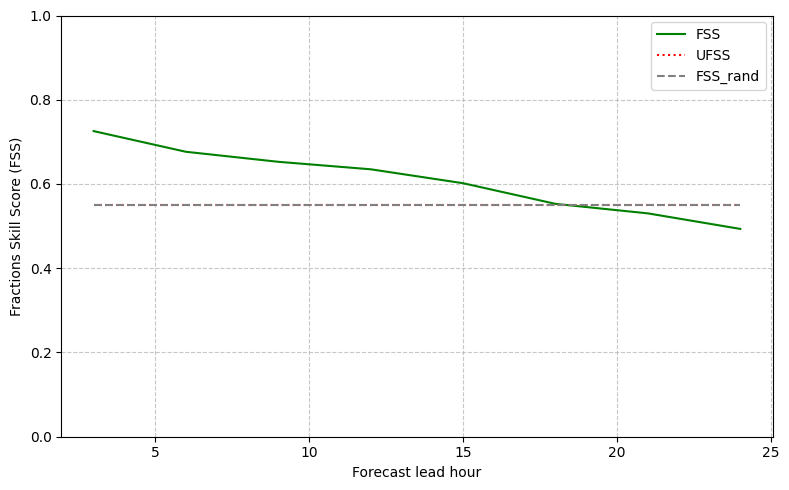

In [13]:
plt.figure(figsize=(8,5))
plt.plot(fss_out.lead_time.values * 3, fss_out.FSS.values, linestyle='-', color='green', label='FSS')
plt.plot(fss_out.lead_time.values * 3, fss_out.UFSS.values, linestyle=':', color='red', label='UFSS')
plt.plot(fss_out.lead_time.values * 3, fss_out.FSS_rand.values, linestyle='--', color='gray', label='FSS_rand')

plt.xlabel('Forecast lead hour')
plt.ylabel('Fractions Skill Score (FSS)')
plt.ylim([0, 1])

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In this example, both benchmarks achieve similar FSS value. However, it is important to note that `FSS_rand` is computed over the neighborhood window, whereas `UFSS` is calculated at the grid scale. As a result, `UFSS` remains constant regardless of neighborhood size, while value of `FSS_rand` varies as the neighborhood size changes. 

As expected, the forecast skill decreases with increasing lead time. When comparing the FSS values against the benchmarks, the forecast demonstrates skill for the first six lead times (up to 18 hours). Beyond that, the FSS drops below the benchmark, indicating a loss of skill.

**Exercise - multiple windows/thresholds:** An exercise is left to the reader to implement a similar method to support multiple input args for `fss_2d`. See: "4. Multiple Inputs" in the previous section for an idea. Note that this version would be slightly trickier since the result of `fss_2d` is not necessarily a scalar, however, there are still many approaches to solving this.

#### 2a. Binary input ####

We can also run FSS with binary inputs. In this part we will repeat the above computation, except we will use a pre-discretized input, e.g. using
`scores.processing.discretise.comparative_discretise` and passing the result into `scores.spatial.fss_2d` and we also need to set `is_input_binary=True`. Note that the default threshold operator for `fss_2d` is `np.greater`. So for a fair comparison, we will have to use the ">" mode using `comparative_discretise`.


In [14]:
threshold = 0.5
window_size = (100, 100)

# pre-discretise the inputs
da_fcst_binary = comparative_discretise(da_fcst, threshold, ">")
da_obs_binary = comparative_discretise(da_obs, threshold, ">")

fss_out = fss_2d(
    da_fcst_binary,
    da_obs_binary,
    window_size=window_size,
    spatial_dims=["lat", "lon"],
    preserve_dims=["lead_time"],
    is_input_binary=True,
    check_boolean=False,
    padding='reflective',
    benchmark='both'
)

fss_out

<xarray.Dataset> Size: 384B
Dimensions:    (lead_time: 8)
Coordinates:
  * lead_time  (lead_time) int64 64B 1 2 3 4 5 6 7 8
Data variables:
    FSS        (lead_time) float64 64B 0.7256 0.6764 0.6527 ... 0.5302 0.4933
    FBS        (lead_time) float64 64B 0.04043 0.05498 0.06314 ... 0.1218 0.1473
    FBS_ref    (lead_time) float64 64B 0.1473 0.1699 0.1818 ... 0.2593 0.2908
    UFSS       (lead_time) float64 64B 0.5512 0.5512 0.5512 ... 0.5512 0.5512
    FSS_rand   (lead_time) float64 64B 0.5496 0.5496 0.5496 ... 0.5496 0.5496

**Result:** We see that this is the same result as the previous example.

## Things to try next

- Visualize FSS and benchmark values across a range of thresholds and neighborhood window sizes..
- Examine whether UFSS and FSS_rand can produce conflicting assessments of forecast skill (i.e., cases where one benchmark indicates skill while the other does not).
- Derive theoretical convergence of FSS, for a given threshold. Verify using simulations.
- Extend the application of FSS to alternative distributions (e.g., uniform, beta, or more complex forms), and assess the validity of the results.
- Experiment with various padding strategies and compare their impact on FSS outcomes.

## References

1. [Roberts, N. M., & Lean, H. W. (2008). Scale-selective verification of rainfall accumulations from high-resolution forecasts of convective events. Monthly Weather Review, 136(1), 78-97.][1]
2. [Faggian, N., Roux, B., Steinle, P., & Ebert, B. (2015). Fast calculation of the fractions skill score. Mausam, 66(3), 457-466.][2]
3. [Summed-area table][3]
4. [Mittermaier, M. P. (2025). Is there any skill in daily global precipitation forecasts over the Maritime Continent?. Quarterly Journal of the Royal Meteorological Society, 151(767), e4877.][4]
5. [Antonio, B., & Aitchison, L. (2025). How to derive skill from the Fractions Skill Score. Monthly Weather Review, 153(6), 1021-1033.][5]

[1]: https://doi.org/10.1175/2007MWR2123.1
[2]: http://dx.doi.org/10.54302/mausam.v66i3.555
[3]: https://en.wikipedia.org/wiki/Summed-area_table
[4]: https://doi.org/10.1002/qj.4877
[5]: https://doi.org/10.1175/MWR-D-24-0120.1

## Appendix

**Accumulated FSS Algorithm**

```
Let's assume our data set is of the form lat x lon x time x lead_time => N x M x T x L
where,
    lat x lon = spatial dims
 
1. [Map] Map the input field into a list of fields to be aggregated over. i.e.

        lat x lon x time x lead_time -> [lat x lon] x lead_time,
        where,
            [lat x lon] is a list of T spatial fields.
            keep_dim = lead_time; spatial_dims = lat, lon; collapse_dim = time

2. [Compute] For each lead time compute the decomposed fss score for [lat x lon] (len = T).
    
        The decomposed FSS score is a tuple containing the components required
        to formulate the inal score:
        
        (obs_sum / T, fcst_sum / T, (obs_sum - fcst_sum) / T)

        The division by T is optional, but good to have for larger datasets to
        avoid integer overflow issues when aggregating.

3. [Reduce] Sum the decomposed score across the accumulated dimension.

        fss <- [0; 1 x L]
        for each leadtime, lt {
            obs_sum <- sum_T(fss_decomposed[lt][0])
            fcst_sum <- sum_T(fss_decomposed[lt][1])
            diff_sum <- sum_T(fss_decomposed[lt][2])
            fss[lt] <- dff_sum / (obs_sum + fcst_sum)
        }
        return fss :: size := 1 x L


The reason why we need to keep track of the decomposed score instead of simply
aggregating the final score is because:

1/x + 1/y != 1 / (x+y)
```